c:\Users\smhrd\anaconda3\envs\rp-gpu\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\smhrd\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Epoch 1/10
3227/3227 [==============================] - 567s 171ms/step - loss: 1.3394 - accuracy: 0.5030 - val_loss: 1.4959 - val_accuracy: 0.4513
Epoch 2/10
3227/3227 [==============================] - 557s 173ms/step - loss: 0.9446 - accuracy: 0.6764 - val_loss: 1.4787 - val_accuracy: 0.4635
Epoch 3/10
3227/3227 [==============================] - 556s 172ms/step - loss: 0.8401 - accuracy: 0.7110 - val_loss: 1.4998 - val_accuracy: 0.4787
Epoch 4/10
3227/3227 [==============================] - 572s 177ms/step - loss: 0.7982 - accuracy: 0.7252 - val_loss: 1.4652 - val_accuracy: 0.4953
Epoch 5/10
3227/3227 [==============================] - 578s 179ms/step - loss: 0.7646 - accuracy: 0.7371 - val_loss: 1.4704 - val_accuracy: 0.5096
Epoch 6/10
3227/3227 [==============================] - 576s 178ms/step - loss: 0.7347 - accuracy: 0.7461 - val_loss: 1.4711 - val_accuracy: 0.5100
Epoch 7/10
3227/3227 [==============================] - 577s 179ms/step - loss: 0.7127 - accuracy: 0.7545 - val_

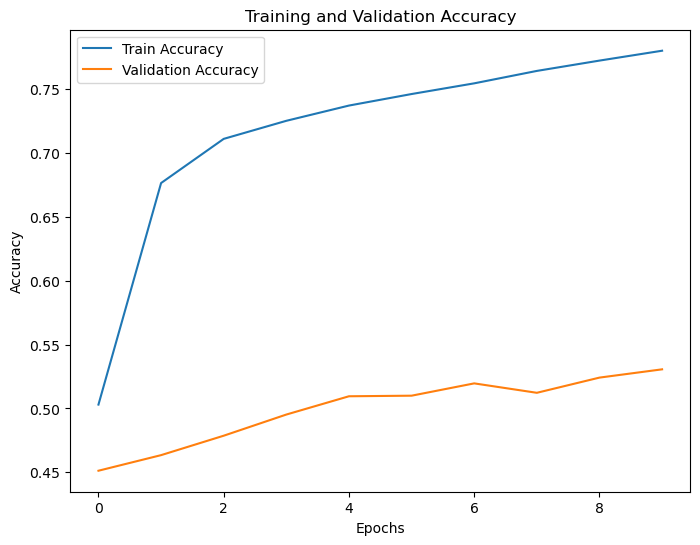

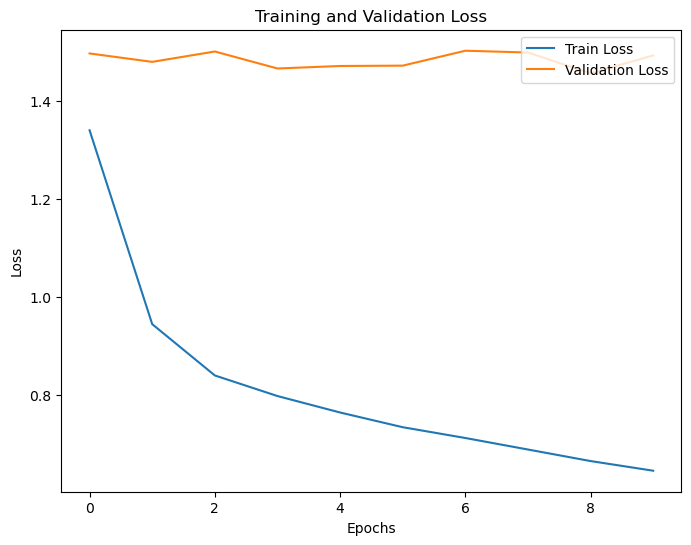

In [3]:
# 에포크 선정!

import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder



# 학습데이터 불러오기

# xlsx 파일 경로
file_path = '../감성대화말뭉치(최종데이터)_Training.xlsx'
# xlsx 파일 읽기
dataframe = pd.read_excel(file_path)

# 검증데이터 불러오기

# xlsx 파일 경로
file_path = '../감성대화말뭉치(최종데이터)_Validation.xlsx'
# xlsx 파일 읽기
val_dataframe = pd.read_excel(file_path)

# 학습 데이터와 검증 데이터 설정
train_features = dataframe['사람문장1'].fillna("") +" "+ dataframe['시스템문장1'].fillna("") +" "+ dataframe['사람문장2'].fillna("") +" "+ dataframe['시스템문장2'].fillna("") +" "+ dataframe['사람문장3'].fillna("") +" "+ dataframe['시스템문장3'].fillna("")  # 학습 데이터 입력 (문장)
train_labels = dataframe['감정_대분류']    # 학습 데이터 출력 라벨 (감정 클래스)

val_features = val_dataframe['사람문장1'].fillna("") + " " + val_dataframe['시스템문장1'].fillna("") + " " + val_dataframe['사람문장2'].fillna("") + " " + val_dataframe['시스템문장2'].fillna("") + " " + val_dataframe['사람문장3'].fillna("") + " " + val_dataframe['시스템문장3'].fillna("")   # 검증 데이터 입력 (문장)
val_labels = val_dataframe['감정_대분류']      # 검증 데이터 출력 라벨 (감정 클래스)


# 레이블 인코딩
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)


# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")


# 입력 데이터를 토큰화하고 인코딩
train_encodings = tokenizer(list(train_features), truncation=True, padding=True)
val_encodings = tokenizer(list(val_features), truncation=True, padding=True)

# 데이터셋 생성
train_encoded_labels = tf.one_hot(train_labels, depth=len(encoder.classes_))
val_encoded_labels = tf.one_hot(val_labels, depth=len(encoder.classes_))
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_encoded_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_encoded_labels))

# 모델 로드
model = TFElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator", from_pt=True, num_labels=len(encoder.classes_), force_download=True)


# 훈련 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


# 훈련
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=10, batch_size=16, validation_data=val_dataset.batch(16))

def plot_history(history):
    # 정확도 그래프
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

    # 손실값 그래프
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

# 시각화 함수 호출
plot_history(history)

In [1]:
import pandas as pd

# 학습데이터 불러오기

# xlsx 파일 경로
file_path = '../감성대화말뭉치(최종데이터)_Training.xlsx'
# xlsx 파일 읽기
dataframe = pd.read_excel(file_path)

# 검증데이터 불러오기

# xlsx 파일 경로
file_path = '../감성대화말뭉치(최종데이터)_Validation.xlsx'
# xlsx 파일 읽기
val_dataframe = pd.read_excel(file_path)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Epoch 1/20
3227/3227 [==============================] - 586s 178ms/step - loss: 1.3691 - accuracy: 0.4564 - val_loss: 1.4762 - val_accuracy: 0.4289
Epoch 2/20
3227/3227 [==============================] - 581s 180ms/step - loss: 1.0240 - accuracy: 0.6329 - val_loss: 1.4910 - val_accuracy: 0.4802
Epoch 3/20
3227/3227 [==============================] - 581s 180ms/step - loss: 0.8706 - accuracy: 0.6986 - val_loss: 1.3578 - val_accuracy: 0.5257
Epoch 4/20
3227/3227 [==============================] - 581s 180ms/step - loss: 0.8008 - accuracy: 0.7231 - val_loss: 1.4916 - val_accuracy: 0.4987
Epoch 5/20
3227/3227 [==============================] - 580s 180ms/step - loss: 0.7661 - accuracy: 0.7353 - val_loss: 1.5036 - val_accuracy: 0.5017
Epoch 6/20
3227/3227 [==============================] - 580s 180ms/step - loss: 0.7388 - accuracy: 0.7457 - val_loss: 1.4863 - val_accuracy: 0.5029
Epoch 7/20
3227/3227 [==============================] - 581s 180ms/step - loss: 0.7085 - accuracy: 0.7565 - val_

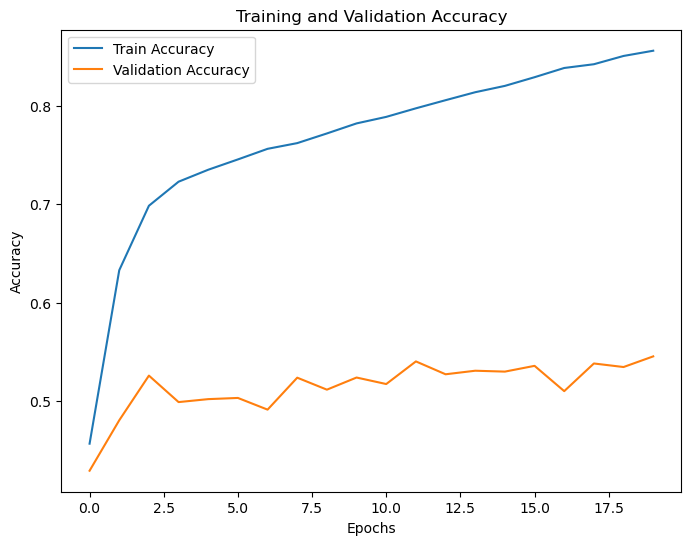

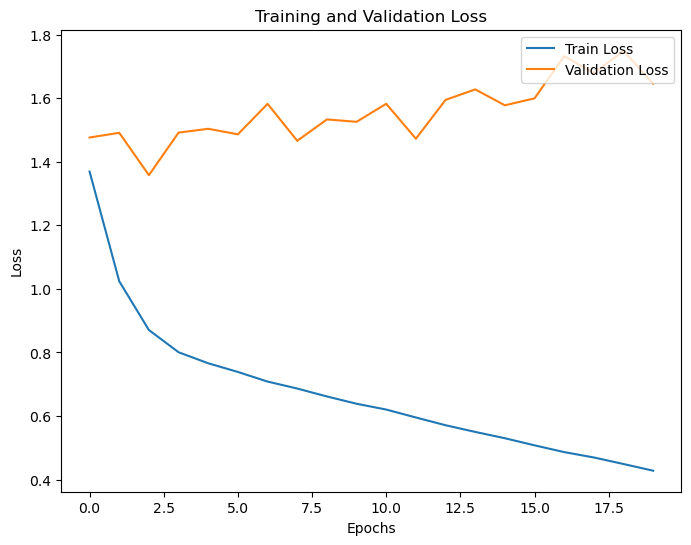

In [4]:
# 에포크 선정!(20까지)

import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder



# 학습데이터 불러오기

# xlsx 파일 경로
file_path = '../감성대화말뭉치(최종데이터)_Training.xlsx'
# xlsx 파일 읽기
dataframe = pd.read_excel(file_path)

# 검증데이터 불러오기

# xlsx 파일 경로
file_path = '../감성대화말뭉치(최종데이터)_Validation.xlsx'
# xlsx 파일 읽기
val_dataframe = pd.read_excel(file_path)

# 학습 데이터와 검증 데이터 설정
train_features = dataframe['사람문장1'].fillna("") +" "+ dataframe['시스템문장1'].fillna("") +" "+ dataframe['사람문장2'].fillna("") +" "+ dataframe['시스템문장2'].fillna("") +" "+ dataframe['사람문장3'].fillna("") +" "+ dataframe['시스템문장3'].fillna("")  # 학습 데이터 입력 (문장)
train_labels = dataframe['감정_대분류']    # 학습 데이터 출력 라벨 (감정 클래스)

val_features = val_dataframe['사람문장1'].fillna("") + " " + val_dataframe['시스템문장1'].fillna("") + " " + val_dataframe['사람문장2'].fillna("") + " " + val_dataframe['시스템문장2'].fillna("") + " " + val_dataframe['사람문장3'].fillna("") + " " + val_dataframe['시스템문장3'].fillna("")   # 검증 데이터 입력 (문장)
val_labels = val_dataframe['감정_대분류']      # 검증 데이터 출력 라벨 (감정 클래스)


# 레이블 인코딩
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)


# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")


# 입력 데이터를 토큰화하고 인코딩
train_encodings = tokenizer(list(train_features), truncation=True, padding=True)
val_encodings = tokenizer(list(val_features), truncation=True, padding=True)

# 데이터셋 생성
train_encoded_labels = tf.one_hot(train_labels, depth=len(encoder.classes_))
val_encoded_labels = tf.one_hot(val_labels, depth=len(encoder.classes_))
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_encoded_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_encoded_labels))

# 모델 로드
model = TFElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator", from_pt=True, num_labels=len(encoder.classes_), force_download=True)


# 훈련 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


# 훈련
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=20, batch_size=16, validation_data=val_dataset.batch(16))

def plot_history(history):
    # 정확도 그래프
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

    # 손실값 그래프
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

# 시각화 함수 호출
plot_history(history)

In [2]:
# 모델 저장!!!

import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import pandas as pd


# 학습데이터 불러오기
file_path = '../감성대화말뭉치(최종데이터)_Training.xlsx'
dataframe = pd.read_excel(file_path)

# 학습 데이터 설정
train_features = dataframe['사람문장1'].fillna("") +" "+ dataframe['시스템문장1'].fillna("") +" "+ dataframe['사람문장2'].fillna("") +" "+ dataframe['시스템문장2'].fillna("") +" "+ dataframe['사람문장3'].fillna("") +" "+ dataframe['시스템문장3'].fillna("")  # 학습 데이터 입력 (문장)
train_labels = dataframe['감정_대분류']    # 학습 데이터 출력 라벨 (감정 클래스)

# 레이블 인코딩
encoder = LabelEncoder()
train_labels = encoder.fit_transform(train_labels)

print("인코딩된 레이블:")
for label, encoded_label in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"{label}: {encoded_label}")


# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 입력 데이터를 토큰화하고 인코딩
train_encodings = tokenizer(list(train_features), truncation=True, padding=True)

# 데이터셋 생성
train_encoded_labels = tf.one_hot(train_labels, depth=len(encoder.classes_))
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_encoded_labels))

# 모델 로드
model = TFElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator", from_pt=True, num_labels=len(encoder.classes_), force_download=True)

# 훈련 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 훈련
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=8, batch_size=16)

# 모델 저장
model.save_pretrained("saved_modelss")

인코딩된 레이블:
기쁨: 0
당황: 1
분노: 2
불안: 3
상처: 4
슬픔: 5


c:\Users\smhrd\anaconda3\envs\rp-gpu\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\smhrd\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Epoch 1/8
3227/3227 [==============================] - 546s 165ms/step - loss: 1.3709 - accuracy: 0.4669
Epoch 2/8
3227/3227 [==============================] - 533s 165ms/step - loss: 0.9738 - accuracy: 0.6594
Epoch 3/8
3227/3227 [==============================] - 533s 165ms/step - loss: 0.8593 - accuracy: 0.7009
Epoch 4/8
3227/3227 [==============================] - 541s 168ms/step - loss: 0.8015 - accuracy: 0.7217
Epoch 5/8
3227/3227 [==============================] - 547s 170ms/step - loss: 0.7690 - accuracy: 0.7349
Epoch 6/8
3227/3227 [==============================] - 557s 173ms/step - loss: 0.7418 - accuracy: 0.7445
Epoch 7/8
3227/3227 [==============================] - 539s 167ms/step - loss: 0.7163 - accuracy: 0.7541
Epoch 8/8
3227/3227 [==============================] - 541s 168ms/step - loss: 0.6937 - accuracy: 0.7619


In [ ]:
# 인코딩된 레이블:
# 기쁨: 0
# 당황: 1
# 분노: 2
# 불안: 3
# 상처: 4
# 슬픔: 5

In [3]:
# 샘플 출력!!

import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np

# CSV 파일 경로
file_path = "../r_리뷰 데이터.csv"

# CSV 파일 읽기
dataframe = pd.read_csv(file_path)

reply = dataframe['reply'][0:10]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 입력 데이터를 토큰화하고 인코딩
reply_encodings = tokenizer(list(reply), truncation=True, padding=True)

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 입력 데이터를 TensorFlow Dataset으로 변환
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

# 예측 수행
predictions = loaded_model.predict(dataset)

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정


# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])

# 예측 결과 출력
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = dataframe['reply'][i]
    novel_no = dataframe['novel_no'][i]
    results_df.loc[i] = [novel_no, review, predicted_emotion]

# 결과 데이터프레임 출력
print(results_df)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


1/1 [==============================] - 3s 3s/step
   novel_no                                                 리뷰 예측 감정
0   1518266  마스카라가 아니고 속눈썹이 맞는 것 같은데... 마스카라는 속눈썹 길게 하려고 바르...    상처
1   1518266                  아.. 게임판타지가 아니라.. 카지노게임? 로맨스? 성인물?    상처
2   1518266                                         재밌게봤어요~~^^    상처
3   1518266  소재는 좋은데 디태일이 많이 부족한 상태로 스토리를 끌고 간거 같아 재미가 반감됐네...    불안
4   1518266                    잼나요. ㅋ. 스토리구성도. 약간은 억지도있지만. . .    슬픔
5   1518266                                        재밌네요 정주행시작!    분노
6   1518266                                             대박~~~~    기쁨
7   1296960                                                  ㅎ    분노
8   1296960  헐 업뎃날짜가 6월달이라....이거 완결은 언제 되는거임?? 괜히 읽었단 생각이,,...    상처
9   1296960                대체 무슨 이야기를 하고 싶은건지...이해가 안됨. 편수만 많음    불안


In [4]:
import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np

# CSV 파일 경로
file_path = "../r_리뷰 데이터.csv"

# CSV 파일 읽기
dataframe = pd.read_csv(file_path)

# 전체 리뷰 데이터
reply = dataframe['reply']  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 전체 리뷰 데이터를 여러 개의 작은 배치로 분할
batch_size = 10000  # 각 배치의 크기
num_batches = len(reply) // batch_size  # 배치의 개수

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])

# 각 배치별로 예측 수행
for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = (batch_index + 1) * batch_size

    # 배치 데이터 준비
    batch_reply = reply[start_index:end_index]
    reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
    predictions = loaded_model.predict(dataset)

    # 배치 결과 저장
    for i, prediction in enumerate(predictions.logits):
        predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
        predicted_emotion = label_mapping[predicted_label]
        review = batch_reply[i+start_index]
        novel_no = dataframe['novel_no'][start_index + i]
        results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
    results_df.to_csv("results_ss.csv", index=False)

# 남은 리뷰 처리 (마지막 배치)
start_index = num_batches * batch_size
end_index = len(reply)

# 남은 리뷰 데이터 준비
batch_reply = reply[start_index:end_index]
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

# 남은 리뷰 예측 수행
predictions = loaded_model.predict(dataset)

# 남은 리뷰 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+start_index]
    novel_no = dataframe['novel_no'][start_index + i]
    results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]

# 남은 리뷰 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_ss.csv", index=False)


# 전체 배치 결과를 CSV 파일로 저장
results_df.to_csv("results_ss.csv", index=False)

# 결과 데이터프레임 출력
print(results_df)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


313/313 [==============================] - 41s 132ms/step


ValueError: Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [6]:
review

'애기 낳고 오순도순 외전이오 ㅠㅠ'

In [8]:
start_index+1

1110001

In [9]:
batch_reply

1110000                                           외전 더 없나요??
1110001                         엥 왜케 평이 안 좋지...난 그냥 저냥 ㅇㅋ였는뎅
1110002                                            괜히 전체 삼..
1110003                                   ??이 분은 또 유리를 좋아해!?
1110004                                             이제 구르겠네요
                                 ...                        
1119995                     남주가 양보해라 한 번 끼면 반지 안뺀다고 하잖아 서윤이가
1119996           결말이 어찌되든 너하고 상관 없는 일이다 태준아 !!! 예의좀 갖추지 !!!
1119997                                           맞아 발정난 OOO
1119998    태준이도 OOO인데 소속사 대표도 쓰레기고만ㅡ.ㅡ 직원을 그것도 유부녀를 ㅡ.ㅡ 아...
1119999    여주왜이래ㅡ.ㅡ 남편한테 섭섭한거는 섭섭한거고... 아주버님이 그렇다면 끈어달라고 ...
Name: reply, Length: 10000, dtype: object

In [11]:
reply[1110000:]

1110000                                 외전 더 없나요??
1110001               엥 왜케 평이 안 좋지...난 그냥 저냥 ㅇㅋ였는뎅
1110002                                  괜히 전체 삼..
1110003                         ??이 분은 또 유리를 좋아해!?
1110004                                   이제 구르겠네요
                            ...                   
1445757                             헐 첫화부터 애간장 끓네요
1445758                           아고ㅜㅜ 정주행 시작이요~~~
1445759                             장어덮밥..태준이 나이스♡
1445760    작가님^^ 소은이..마음이 찡하네요ㅠㅠ 첫글보러왔어요.♡ 너무기대됩니다
1445761                                    1등~~~^^
Name: reply, Length: 335762, dtype: object

In [51]:
# 짤린 부분 추가로 csv 파일로 생성

import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np

# 나머지 리뷰 데이터
reply_last1 = reply[1110000:1110073]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 배치 데이터 준비
batch_reply = reply_last1
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
predictions = loaded_model.predict(dataset)

# 배치 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+1110000]
    novel_no = dataframe['novel_no'][1110000 + i]
    results_df.loc[1110000 + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast1.csv", index=False)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


3/3 [==============================] - 3s 39ms/step


In [53]:
import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np


# 나머지 리뷰 데이터
reply_last1 = reply[1110083:]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 전체 리뷰 데이터를 여러 개의 작은 배치로 분할
batch_size = 10000  # 각 배치의 크기
num_batches = len(reply_last1) // batch_size  # 배치의 개수

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 각 배치별로 예측 수행
for batch_index in range(num_batches):
    start_index = (batch_index) * batch_size + 1110083
    end_index = (batch_index + 1) * batch_size + 1110083

    # 배치 데이터 준비
    batch_reply = reply[start_index:end_index]
    reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
    predictions = loaded_model.predict(dataset)

    # 배치 결과 저장
    for i, prediction in enumerate(predictions.logits):
        predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
        predicted_emotion = label_mapping[predicted_label]
        review = batch_reply[i+start_index]
        novel_no = dataframe['novel_no'][start_index + i]
        results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
    results_df.to_csv("results_sslast2.csv", index=False)

# 남은 리뷰 처리 (마지막 배치)
start_index = num_batches * batch_size + 1110083
end_index = len(reply_last1)

# 남은 리뷰 데이터 준비
batch_reply = reply[start_index:end_index]
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

# 남은 리뷰 예측 수행
predictions = loaded_model.predict(dataset)

# 남은 리뷰 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+start_index]
    novel_no = dataframe['novel_no'][start_index + i]
    results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]

# 남은 리뷰 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast2.csv", index=False)


# 전체 배치 결과를 CSV 파일로 저장
results_df.to_csv("results_sslast2.csv", index=False)

# 결과 데이터프레임 출력
print(results_df)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


313/313 [==============================] - 42s 125ms/step


ValueError: Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [54]:
# 짤린 부분 추가로 csv 파일로 생성

import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np

# 나머지 리뷰 데이터
reply_last1 = reply[1120083:1120519]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 배치 데이터 준비
batch_reply = reply_last1
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
predictions = loaded_model.predict(dataset)

# 배치 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+1120083]
    novel_no = dataframe['novel_no'][1120083 + i]
    results_df.loc[1120083 + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast3.csv", index=False)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


14/14 [==============================] - 4s 73ms/step


In [55]:
import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np


# 나머지 리뷰 데이터
reply_last1 = reply[1120534:]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 전체 리뷰 데이터를 여러 개의 작은 배치로 분할
batch_size = 10000  # 각 배치의 크기
num_batches = len(reply_last1) // batch_size  # 배치의 개수

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 각 배치별로 예측 수행
for batch_index in range(num_batches):
    start_index = (batch_index) * batch_size + 1120534
    end_index = (batch_index + 1) * batch_size + 1120534

    # 배치 데이터 준비
    batch_reply = reply[start_index:end_index]
    reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
    predictions = loaded_model.predict(dataset)

    # 배치 결과 저장
    for i, prediction in enumerate(predictions.logits):
        predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
        predicted_emotion = label_mapping[predicted_label]
        review = batch_reply[i+start_index]
        novel_no = dataframe['novel_no'][start_index + i]
        results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
    results_df.to_csv("results_sslast4.csv", index=False)

# 남은 리뷰 처리 (마지막 배치)
start_index = num_batches * batch_size + 1120534
end_index = len(reply_last1)

# 남은 리뷰 데이터 준비
batch_reply = reply[start_index:end_index]
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

# 남은 리뷰 예측 수행
predictions = loaded_model.predict(dataset)

# 남은 리뷰 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+start_index]
    novel_no = dataframe['novel_no'][start_index + i]
    results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]

# 남은 리뷰 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast4.csv", index=False)


# 전체 배치 결과를 CSV 파일로 저장
results_df.to_csv("results_sslast4.csv", index=False)

# 결과 데이터프레임 출력
print(results_df)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


313/313 [==============================] - 32s 93ms/step


ValueError: Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

In [61]:
# 짤린 부분 추가로 csv 파일로 생성

import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np

# 나머지 리뷰 데이터
reply_last1 = reply[1140534:1141634]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 배치 데이터 준비
batch_reply = reply_last1
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
predictions = loaded_model.predict(dataset)

# 배치 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+1140534]
    novel_no = dataframe['novel_no'][1140534 + i]
    results_df.loc[1120083 + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast5.csv", index=False)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


35/35 [==============================] - 6s 92ms/step


In [58]:
# 짤린 부분 추가로 csv 파일로 생성

import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np

# 나머지 리뷰 데이터
reply_last1 = reply[1141649:1146062]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 배치 데이터 준비
batch_reply = reply_last1
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
predictions = loaded_model.predict(dataset)

# 배치 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+1141649]
    novel_no = dataframe['novel_no'][1141649 + i]
    results_df.loc[1141649 + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast6.csv", index=False)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


138/138 [==============================] - 22s 117ms/step


In [59]:
import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np


# 나머지 리뷰 데이터
reply_last1 = reply[1146070:]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 전체 리뷰 데이터를 여러 개의 작은 배치로 분할
batch_size = 10000  # 각 배치의 크기
num_batches = len(reply_last1) // batch_size  # 배치의 개수

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 각 배치별로 예측 수행
for batch_index in range(num_batches):
    start_index = (batch_index) * batch_size + 1146070
    end_index = (batch_index + 1) * batch_size + 1146070

    # 배치 데이터 준비
    batch_reply = reply[start_index:end_index]
    reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
    predictions = loaded_model.predict(dataset)

    # 배치 결과 저장
    for i, prediction in enumerate(predictions.logits):
        predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
        predicted_emotion = label_mapping[predicted_label]
        review = batch_reply[i+start_index]
        novel_no = dataframe['novel_no'][start_index + i]
        results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
    results_df.to_csv("results_sslast7.csv", index=False)

# 남은 리뷰 처리 (마지막 배치)
start_index = num_batches * batch_size + 1146070
end_index = len(reply_last1)

# 남은 리뷰 데이터 준비
batch_reply = reply[start_index:end_index]
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

# 남은 리뷰 예측 수행
predictions = loaded_model.predict(dataset)

# 남은 리뷰 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+start_index]
    novel_no = dataframe['novel_no'][start_index + i]
    results_df.loc[start_index + i] = [novel_no, review, predicted_emotion]

# 남은 리뷰 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast7.csv", index=False)


# 전체 배치 결과를 CSV 파일로 저장
results_df.to_csv("results_sslast7.csv", index=False)

# 결과 데이터프레임 출력
print(results_df)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


313/313 [==============================] - 38s 122ms/step


ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided []

In [60]:
# 짤린 부분 추가로 csv 파일로 생성

import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification
import tensorflow as tf
import numpy as np

# 나머지 리뷰 데이터
reply_last1 = reply[1436070:]  # 리뷰 데이터 (문장)

# Electra 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

# 모델 로드
loaded_model = TFElectraForSequenceClassification.from_pretrained("saved_modelss")

# 감정 레이블 매핑
label_mapping = {0: "기쁨", 1: "당황", 2: "분노", 3: "불안", 4: "상처", 5:"슬픔"}  # 감정 레이블에 맞게 수정

# 예측 결과를 담을 데이터프레임 생성
results_df = pd.DataFrame(columns=["novel_no", "리뷰", "예측 감정"])


# 배치 데이터 준비
batch_reply = reply_last1
reply_encodings = tokenizer(list(batch_reply), truncation=True, padding=True)
dataset = tf.data.Dataset.from_tensor_slices((dict(reply_encodings), None)).batch(32)

    # 배치 예측 수행
predictions = loaded_model.predict(dataset)

# 배치 결과 저장
for i, prediction in enumerate(predictions.logits):
    predicted_label = np.argmax(prediction)  # 가장 큰 값의 인덱스 가져오기
    predicted_emotion = label_mapping[predicted_label]
    review = batch_reply[i+1436070]
    novel_no = dataframe['novel_no'][1436070 + i]
    results_df.loc[1436070 + i] = [novel_no, review, predicted_emotion]
        
    # 배치 결과를 CSV 파일로 저장 - 하나로 덮어씀
results_df.to_csv("results_sslast8.csv", index=False)

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at saved_modelss.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


303/303 [==============================] - 36s 110ms/step


In [52]:
reply[1110083:]

1110083                                 얼마나 이쁘길래 몇놈이 달라붙냐ㅋㅋㅋ
1110084                                재미 없네여 진행 스토리가 앞뒤가 별로
1110085                               용우 ㄱH새야 , 손목아지를 분질러불라🤬
1110086    끝이 이런건 외전 할꺼라 그런거죠? 요즘은 끝을 하다말고 외전으로 너무 끄는게 맘에...
1110087             좋아하지 말래놓고 왜 자꾸 스킨쉽하는데!!!!! 이나쁜노마!!!!!!!!
                                 ...                        
1445757                                       헐 첫화부터 애간장 끓네요
1445758                                     아고ㅜㅜ 정주행 시작이요~~~
1445759                                       장어덮밥..태준이 나이스♡
1445760              작가님^^ 소은이..마음이 찡하네요ㅠㅠ 첫글보러왔어요.♡ 너무기대됩니다
1445761                                              1등~~~^^
Name: reply, Length: 335679, dtype: object

In [48]:
start_index

0

In [16]:
reply[:10000]

0       마스카라가 아니고 속눈썹이 맞는 것 같은데... 마스카라는 속눈썹 길게 하려고 바르...
1                       아.. 게임판타지가 아니라.. 카지노게임? 로맨스? 성인물?
2                                              재밌게봤어요~~^^
3       소재는 좋은데 디태일이 많이 부족한 상태로 스토리를 끌고 간거 같아 재미가 반감됐네...
4                         잼나요. ㅋ. 스토리구성도. 약간은 억지도있지만. . .
                              ...                        
9995                     탄탄한 구성과 가슴을 시리게하는 내용~ 너무 잘 읽었어요~
9996    잘보았습니다.가벼운 로코물이 아니라는게 오히려 전 좋았습니다. 쉬지않고 보려 집중하...
9997    가벼운 로맨스물 생각하고 봤다가, 뭐지? 뭐지? 하면서, 순식간에 읽어 내려 갔네요...
9998    뉴사는 진리입니다!!가볍게 시작했다가 무서울 정도로 내용에 빨려들어갔어요 허투루 넘...
9999    구성이 매우 산만해요. 죄송하지만 어린 학생이 정리하지않고 머리속에 떠오른것을 그대...
Name: reply, Length: 10000, dtype: object

In [17]:
batch_reply

1110000                                           외전 더 없나요??
1110001                         엥 왜케 평이 안 좋지...난 그냥 저냥 ㅇㅋ였는뎅
1110002                                            괜히 전체 삼..
1110003                                   ??이 분은 또 유리를 좋아해!?
1110004                                             이제 구르겠네요
                                 ...                        
1119995                     남주가 양보해라 한 번 끼면 반지 안뺀다고 하잖아 서윤이가
1119996           결말이 어찌되든 너하고 상관 없는 일이다 태준아 !!! 예의좀 갖추지 !!!
1119997                                           맞아 발정난 OOO
1119998    태준이도 OOO인데 소속사 대표도 쓰레기고만ㅡ.ㅡ 직원을 그것도 유부녀를 ㅡ.ㅡ 아...
1119999    여주왜이래ㅡ.ㅡ 남편한테 섭섭한거는 섭섭한거고... 아주버님이 그렇다면 끈어달라고 ...
Name: reply, Length: 10000, dtype: object

In [20]:
reply[1110000]

'외전 더 없나요??'

In [45]:
type(reply[1110064])

str

In [46]:
list(batch_reply)

['마스카라가 아니고 속눈썹이 맞는 것 같은데... 마스카라는 속눈썹 길게 하려고 바르는.. 건데..',
 '아.. 게임판타지가 아니라.. 카지노게임? 로맨스? 성인물?',
 '재밌게봤어요~~^^',
 '소재는 좋은데 디태일이 많이 부족한 상태로 스토리를 끌고 간거 같아 재미가 반감됐네요..19금을 편집하다보니 내용도 약간 앞뒤 안 맞고..',
 '잼나요. ㅋ. 스토리구성도. 약간은 억지도있지만. . .',
 '재밌네요 정주행시작!',
 '대박~~~~',
 'ㅎ',
 '헐 업뎃날짜가 6월달이라....이거 완결은 언제 되는거임?? 괜히 읽었단 생각이,,,, 너무 무책임한거 아니에여',
 '대체 무슨 이야기를 하고 싶은건지...이해가 안됨. 편수만 많음',
 '북팔에서 연재가 안돼서 살짝 실망했는데 여기서 보니 반갑네요~',
 '흥미진진',
 '산만해서몰입이안됨..무슨내용인지..',
 '곽부실,,이주태재,,,, 이라이자 는 주인공을 괴롭히고 늪으로 빠뜨리게 만든 악질로 생각이 드는데 실제로 누가 그랬을까 ... 현실 에서도 이라이자가 있었기 때문에 캔디가 힘든 인생을 살았다고 생각이 드네,,, 청혼을 한사람은 주태라고 생각 하니까 주태는 이라이자가 아니였으면 좋겠어...... 아름다운 청년 기사 테리우스잖아,,,,',
 '중간부터 살짝ㅇ늘어지는듯 하네요. 그래도 나쁘진 않았습니다',
 '괜찮았어요',
 '재밌어요 진지한 남주와 속깊은 여주 잔잔하니 좋네요',
 '두번째 읽었습니다...잔잔하니 좋네요 ..ㅎ 조미료를 넣지않은 책 같아요 .. 담백하고 소박한 책 ..이 봄에 추천해드립니당~~~',
 '잘봤어요 ^^',
 '에필로그가 없어서 아쉽네요 찬주매니저님도 궁금하공',
 '전 좋았습니다~^^에필이 더 있어도 좋겠단 생각이 드는군요. 찬주매니저님 얘기가 궁금한데 아쉽당^^',
 '잘보고갑니다~~',
 '재미있는데 너무 짧아 휙~ 지나간 느낌입니다. 사건이 있는것도 아니고, 삼각도 아니라 심심한듯. 에피소드가 더 많았으면 좋았을거 같아요~',
 '잔잔하면서간질간질한

In [47]:
batch_reply

0          마스카라가 아니고 속눈썹이 맞는 것 같은데... 마스카라는 속눈썹 길게 하려고 바르...
1                          아.. 게임판타지가 아니라.. 카지노게임? 로맨스? 성인물?
2                                                 재밌게봤어요~~^^
3          소재는 좋은데 디태일이 많이 부족한 상태로 스토리를 끌고 간거 같아 재미가 반감됐네...
4                            잼나요. ㅋ. 스토리구성도. 약간은 억지도있지만. . .
                                 ...                        
1445757                                       헐 첫화부터 애간장 끓네요
1445758                                     아고ㅜㅜ 정주행 시작이요~~~
1445759                                       장어덮밥..태준이 나이스♡
1445760              작가님^^ 소은이..마음이 찡하네요ㅠㅠ 첫글보러왔어요.♡ 너무기대됩니다
1445761                                              1등~~~^^
Name: reply, Length: 1445762, dtype: object